In [1]:
import simpy
import itertools
import numpy as np
import matplotlib.pyplot as plt

## SINGLE-SERVER QUEUEING SYSTEM

Processes
- arrival 
- service

#### Generating all cars

In [2]:
def car(env, name, bcs, driving_time, charge_duration):
    # Simulate driving to Charging Station
    yield env.timeout(driving_time)
    
    # Request one of it's charging stations
    print('car {} is arriving at {:.0f}'.format(name, env.now))
    with bcs.request() as req:
        yield req
        
        # Charge the battery
        print('starting to charge Car {} at {}'.format(name, env.now))
        yield env.timeout(charge_duration)
        print('Car {} finished charging at {}'.format(name, env.now))
    

In [3]:
env = simpy.Environment()
bcs = simpy.Resource(env, capacity=2)
env.process(car(env, "1", bcs, 1, 5))
env.process(car(env, "2", bcs, 2, 5))
env.process(car(env, "3", bcs, 3, 5))
env.process(car(env, "4", bcs, 4, 5))
env.run(until=60)

car 1 is arriving at 1
starting to charge Car 1 at 1
car 2 is arriving at 2
starting to charge Car 2 at 2
car 3 is arriving at 3
car 4 is arriving at 4
Car 1 finished charging at 6
starting to charge Car 3 at 6
Car 2 finished charging at 7
starting to charge Car 4 at 7
Car 3 finished charging at 11
Car 4 finished charging at 12


#### with car generator

In [187]:
sim_time = 100
servers = 4

arrival_rate = 20 #arrivals/hour 
service_rate = 5 #service/hour 

In [188]:
arrival_times = []
start_service_times = []
finish_service_times = []

In [189]:
def car(env, name, queue, charge_duration):
    arrival_time = env.now
    arrival_times.append(arrival_time)
#     print('{} is arriving at {:.2f}'.format(name, env.now))
    with queue.request() as req:
        yield req
        
        # Start serving
        waiting_time = env.now - arrival_time
#         print('starting to serve {} at {:.2f}'.format(name, env.now))
        start_service_times.append(env.now)

        # Finish serving
        yield env.timeout(np.random.exponential(charge_duration))
#         print('{} finished serving at {:.2f}'.format(name, env.now))
        finish_service_times.append(env.now)# - waiting_time - arrival_time)
    

In [190]:
def car_generator(env, queue):
    interarrival_time = 60/arrival_rate
    charge_duration = 60/service_rate
    """Generate new cars that arrive at the gas station."""
    for i in itertools.count():
#     for i in range(1,5):
        yield env.timeout(np.random.exponential(interarrival_time))
        
        env.process(car(env, 'Car %d' % i, queue, charge_duration ))
    return i

In [191]:
env = simpy.Environment()
queue = simpy.Resource(env, capacity=servers)
proc = env.process(car_generator(env, queue))
env.run(until=sim_time)

In [192]:
def acum(l):
#     t = np.arange(0,sim_time,0.01)
    Acum = np.zeros(sim_time*100)
    for e in l:
        idx = int(e*100)
        Acum[idx:]+=1
#     plt.plot(t,l)
#     plt.show()
    return Acum

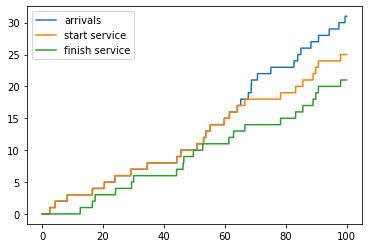

In [193]:
t = np.arange(0,sim_time,0.01)
plt.plot(t,acum(arrival_times), label="arrivals")
plt.plot(t,acum(start_service_times), label="start service")
plt.plot(t,acum(finish_service_times), label="finish service")
# plt.plot(t,acum(waiting_times))
plt.legend()
plt.show()

## SIMULATION OF AN INVENTORY SYSTEM

The **times between demands** are IID exponential random variables with a mean of 0.1 month.

(array([41., 22., 17.,  6.,  4.,  6.,  1.,  2.,  0.,  1.]),
 array([1.86970922e-04, 5.60941411e-02, 1.12001311e-01, 1.67908482e-01,
        2.23815652e-01, 2.79722822e-01, 3.35629992e-01, 3.91537162e-01,
        4.47444333e-01, 5.03351503e-01, 5.59258673e-01]),
 <BarContainer object of 10 artists>)

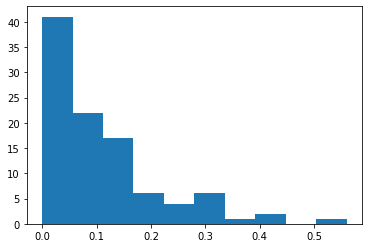

In [4]:
plt.hist(np.random.exponential(0.1, size=100))

The **Demand size** is D, are IID random variables (independent of when the demands occur), with

(array([156.,   0.,   0., 343.,   0.,   0., 339.,   0.,   0., 162.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

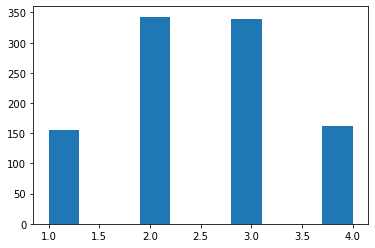

In [22]:
plt.hist(np.random.choice([1,2,3,4],1000, p=[1/6, 1/3, 1/3, 1/6]))

**Order** of Z items

In [24]:
Z = 100

In [30]:
def Z(s,S):
    if I<S:
        return S-I
    return 0

cost and delivery time

In [25]:
def cost_order(Z):
    return 32 + 3*Z
cost_order(Z)

332

(array([15., 11., 12.,  4.,  6.,  9.,  8., 14., 12.,  9.]),
 array([0.50841458, 0.55593814, 0.6034617 , 0.65098526, 0.69850882,
        0.74603238, 0.79355594, 0.8410795 , 0.88860306, 0.93612662,
        0.98365018]),
 <BarContainer object of 10 artists>)

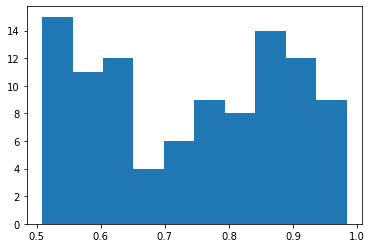

In [29]:
plt.hist([np.random.rand()/2+0.5 for i in range(100)])